# Comparing Air Quality Index in the Contiguous U.S. Across 40 Years

https://cybergisxhub.cigi.illinois.edu/notebook/ggis-407-final-project/

Could not upload the shapefile or the entire zip folder for the county data due to the large size. Data was obtained from the TIGER/Line Shapefiles from the Census Bureau. Year was 2024 and layer type was Counties (and equivalent). https://www.census.gov/cgi-bin/geo/shapefiles/index.php

Inspiration from the uptick in air quality alerts from smoke from Canadian wildfires over the last couple of years. As of 8/5/2025, much of the Midwestern and Northeastern US have air quality alerts from the over 70 wildfires burning in Canada. Climate change is projected to have a negative impact on AQI. Increased temperatures can lead to increased droughts which will in turn promote a higher frequency and intensity of wildfires and more smoke. There could also be an increase of ground ozone which is very detrimental to human health. 

I wanted to see if there is a difference of air quality data in the US over 40 years. I will generate choropleth maps from annual summary data from the EPA and compare the results. 

In [13]:
%matplotlib inline
import os
from datetime import datetime

# set environment variable needed for basemap

os.environ["PROJ_LIB"] = r'/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1006/share/proj/'

import numpy as np
import mpl_toolkits

import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point

In [14]:
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as patches


import cartopy.crs as ccrs # import projection
import cartopy.feature as cf # import features

import json
import folium
import mplleaflet

import IPython

In [15]:
#importing the shapefile with US counties
input_file = 'tl_2024_us_county.zip'
counties = gpd.read_file(input_file)

In [21]:
counties.head()

STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ       NAME   
0      31      039  00835841  31039  0500000US31039     Cuming  \
1      53      069  01513275  53069  0500000US53069  Wahkiakum   
2      35      011  00933054  35011  0500000US35011    De Baca   
3      31      109  00835876  31109  0500000US31109  Lancaster   
4      31      129  00835886  31129  0500000US31129   Nuckolls   

           NAMELSAD LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT   
0     Cuming County   06      H1  G4020  None   None     None        A  \
1  Wahkiakum County   06      H1  G4020  None   None     None        A   
2    De Baca County   06      H1  G4020  None   None     None        A   
3  Lancaster County   06      H1  G4020   339  30700     None        A   
4   Nuckolls County   06      H1  G4020  None   None     None        A   

        ALAND    AWATER     INTPTLAT      INTPTLON   
0  1477563042  10772508  +41.9158651  -096.7885168  \
1   680980773  61564428  +46.2946377  -123.4244583   
2  6016818941  29090018  +34.3592729  -104.3686961   
3  2169269508  22850511  +40.7835474  -096.6886584   
4  1489645201   1718484  +40.1764918  -098.0468422   

                                            geometry  
0  POLYGON ((-96.55525 41.82892, -96.55524 41.827...  
1  POLYGON ((-123.72755 46.26449, -123.72755 46.2...  
2  POLYGON ((-104.89337 34.08894, -104.89337 34.0...  
3  POLYGON ((-96.68493 40.52330, -96.69219 40.523...  
4  POLYGON ((-98.27370 40.11840, -98.27374 40.122...

Reading in data from 2024 with pandas. I worked with one dataset first to see what works and then would replicate with the other 4 data files.

In [16]:
annual_2024 = pd.read_csv('annual_aqi_by_county_2024.csv')
annual_2024.head()

State   County  Year  Days with AQI  Good Days  Moderate Days   
0  Alabama  Baldwin  2024            210        181             29  \
1  Alabama     Clay  2024            212        176             36   
2  Alabama   DeKalb  2024            244        182             62   
3  Alabama   Elmore  2024            144        142              2   
4  Alabama   Etowah  2024            212        125             87   

   Unhealthy for Sensitive Groups Days  Unhealthy Days  Very Unhealthy Days   
0                                    0               0                    0  \
1                                    0               0                    0   
2                                    0               0                    0   
3                                    0               0                    0   
4                                    0               0                    0   

   Hazardous Days  Max AQI  90th Percentile AQI  Median AQI  Days CO   
0               0       84                   53          39        0  \
1               0       75                   53          29        0   
2               0       87                   58          44        0   
3               0       58                   47          37        0   
4               0       93                   61          47        0   

   Days NO2  Days Ozone  Days PM2.5  Days PM10  
0         0          98         112          0  
1         0           0         212          0  
2         0         170          74          0  
3         0         144           0          0  
4         0          57         155          0

In [17]:
# changing the county column to match the county name column in the zip file
df_2024 = annual_2024.rename(columns= {"County":"NAME"})
df_2024.columns

Index(['State', 'NAME', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10'],
      dtype='object')

Merging the dataFrame to the shapefile on the NAME column. 

In [18]:
county_2024 = counties.merge(
    df_2024, on="NAME")
county_2024.head()

STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ       NAME   
0      31      109  00835876  31109  0500000US31109  Lancaster  \
1      31      109  00835876  31109  0500000US31109  Lancaster   
2      45      057  01248008  45057  0500000US45057  Lancaster   
3      45      057  01248008  45057  0500000US45057  Lancaster   
4      42      071  01209181  42071  0500000US42071  Lancaster   

           NAMELSAD LSAD CLASSFP  MTFCC  ... Very Unhealthy Days   
0  Lancaster County   06      H1  G4020  ...                   0  \
1  Lancaster County   06      H1  G4020  ...                   0   
2  Lancaster County   06      H1  G4020  ...                   0   
3  Lancaster County   06      H1  G4020  ...                   0   
4  Lancaster County   06      H1  G4020  ...                   0   

  Hazardous Days Max AQI 90th Percentile AQI  Median AQI  Days CO Days NO2   
0              0      67                  56          43        0        0  \
1              0     125                  72          50        0        0   
2              0      67                  56          43        0        0   
3              0     125                  72          50        0        0   
4              0      67                  56          43        0        0   

  Days Ozone Days PM2.5 Days PM10  
0        111         41         0  
1         83         99         0  
2        111         41         0  
3         83         99         0  
4        111         41         0  

[5 rows x 36 columns]

Creating a choropleth map with the bounding box around the continental US. Black borders added to help visualization. Added quantiles via fisher_jenks. Blank spots on the maps are due to there being no data available for those counties.

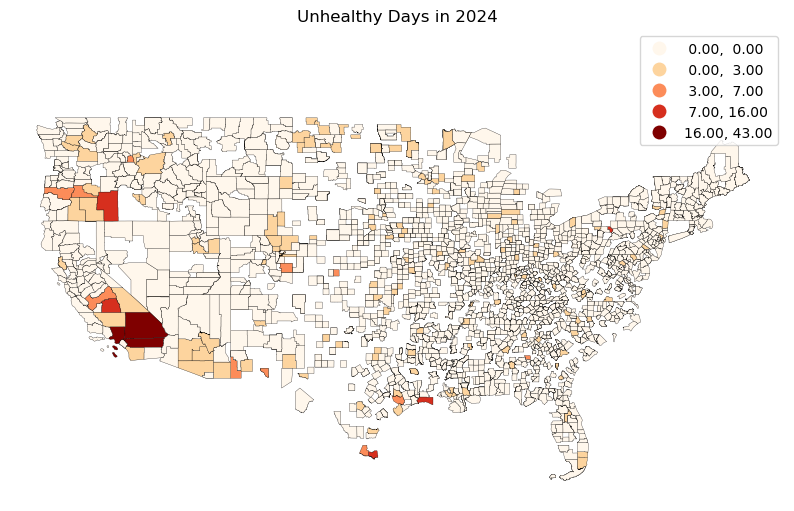

In [60]:
fig, ax = plt.subplots(figsize=(10,8))

# generating a choropleth map with quantiles based on the "Unhealthy Days" column
county_2024.plot(ax=ax, column='Unhealthy Days',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Unhealthy Days in 2024");

# save the generated map to a png
plt.savefig('unhealthy_2024.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Repeated steps with the other 4 files

In [19]:
annual_2014 = pd.read_csv('annual_aqi_by_county_2014.csv')
annual_2004 = pd.read_csv('annual_aqi_by_county_2004.csv')
annual_1994 = pd.read_csv('annual_aqi_by_county_1994.csv')
annual_1984 = pd.read_csv('annual_aqi_by_county_1984.csv')

In [20]:
df_2014 = annual_2014.rename(columns= {"County":"NAME"})
df_2004 = annual_2004.rename(columns= {"County":"NAME"})
df_1994 = annual_1994.rename(columns= {"County":"NAME"})
df_1984 = annual_1984.rename(columns= {"County":"NAME"})

Double checking that column was renamed

In [50]:
df_1984.columns

Index(['State', 'NAME', 'Year', 'Days with AQI', 'Good Days', 'Moderate Days',
       'Unhealthy for Sensitive Groups Days', 'Unhealthy Days',
       'Very Unhealthy Days', 'Hazardous Days', 'Max AQI',
       '90th Percentile AQI', 'Median AQI', 'Days CO', 'Days NO2',
       'Days Ozone', 'Days PM2.5', 'Days PM10'],
      dtype='object')

In [21]:
county_2014 = counties.merge(df_2014, on="NAME")
county_2004 = counties.merge(df_2004, on="NAME")
county_1994 = counties.merge(df_1994, on="NAME")
county_1984 = counties.merge(df_1984, on="NAME")

### Unhealthy Days

Generated maps for "Unhealthy Days" for the rest of the files

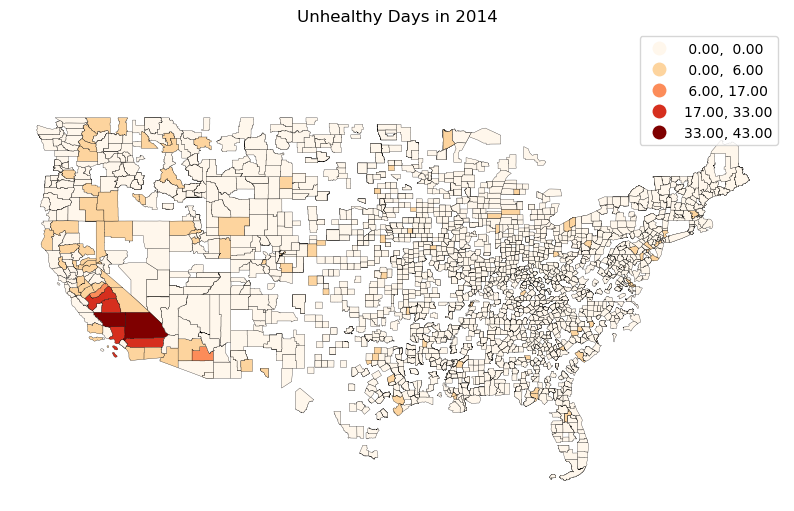

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
county_2014.plot(ax=ax, column='Unhealthy Days',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Unhealthy Days in 2014");
plt.savefig('unhealthy_2014.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

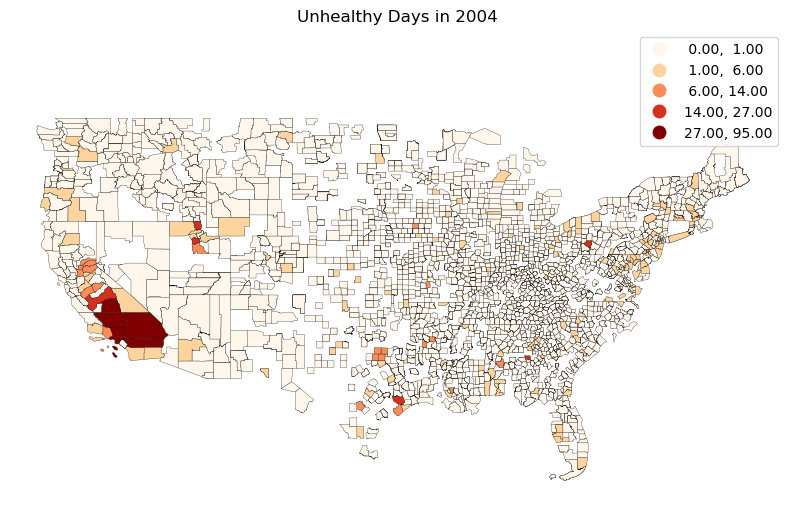

In [54]:
fig, ax = plt.subplots(figsize=(10,8))
county_2004.plot(ax=ax, column='Unhealthy Days',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Unhealthy Days in 2004");
plt.savefig('unhealthy_2004.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

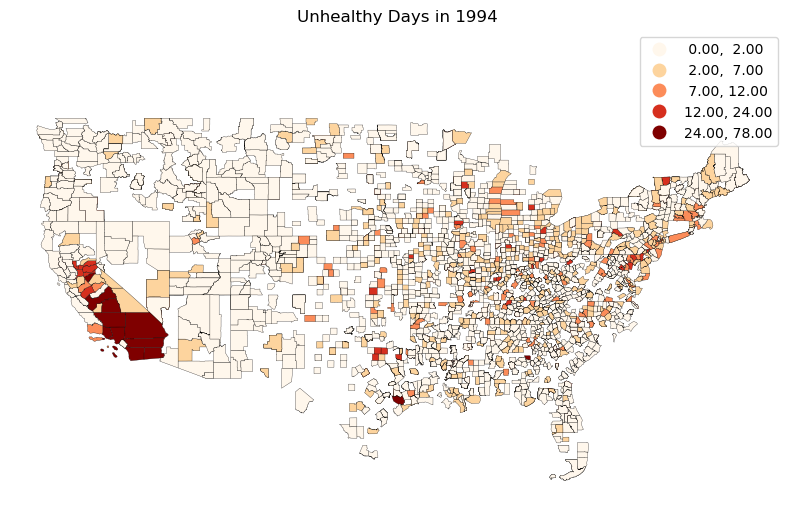

In [56]:
fig, ax = plt.subplots(figsize=(10,8))
county_1994.plot(ax=ax, column='Unhealthy Days',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Unhealthy Days in 1994");
plt.savefig('unhealthy_1994.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

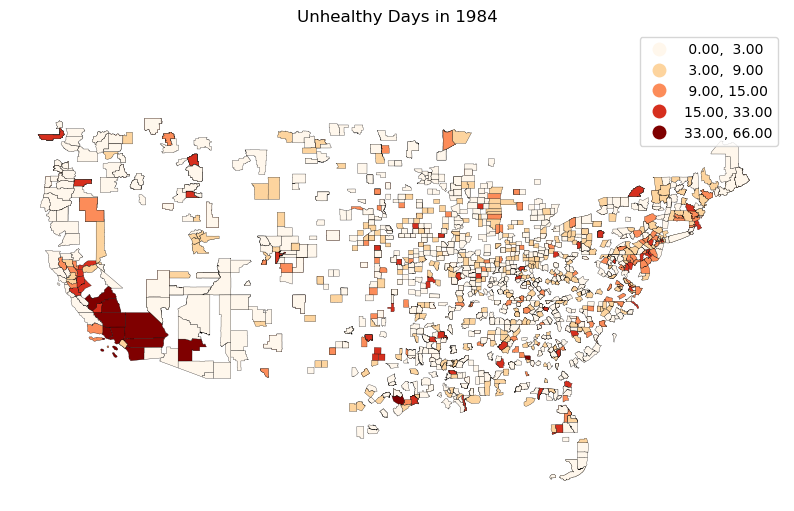

In [57]:
fig, ax = plt.subplots(figsize=(10,8))
county_1984.plot(ax=ax, column='Unhealthy Days',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Unhealthy Days in 1984");
plt.savefig('unhealthy_1984.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

The main difference between 1984 and 2024 is more counties started to have data available. There weren't necessarily more days with Unhealthy AQI levels. It is a little challenging due to the quantiles being different in each year.

### 90th percentile

I next plotted the 90th percentile for AQI. I changed the color map to differentiate these maps. The idea is that the higher the AQI value is to qualify as the 90th percentile, the higher the AQI is getting overall.

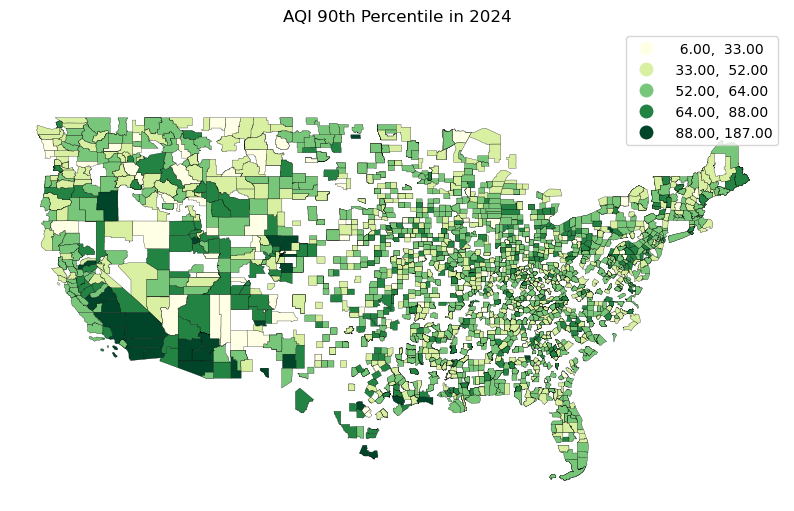

In [64]:
fig, ax = plt.subplots(figsize=(10,8))

# generating a choropleth map with quantiles based on the "90th Percentile" column
# used a different color map to differentiate with the "Unhealthy Days" map
county_2024.plot(ax=ax, column='90th Percentile AQI',
                cmap='YlGn', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("AQI 90th Percentile in 2024");

plt.savefig('90th_2024.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

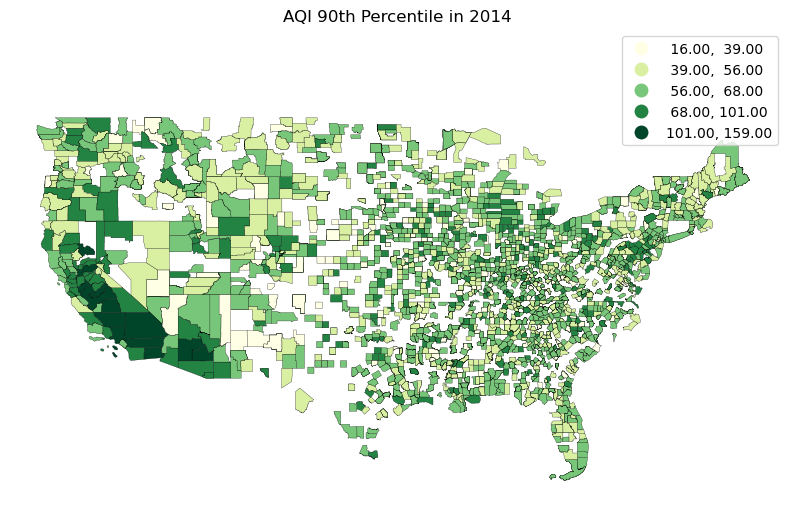

In [65]:
fig, ax = plt.subplots(figsize=(10,8))

county_2014.plot(ax=ax, column='90th Percentile AQI',
                cmap='YlGn', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("AQI 90th Percentile in 2014");

plt.savefig('90th_2014.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

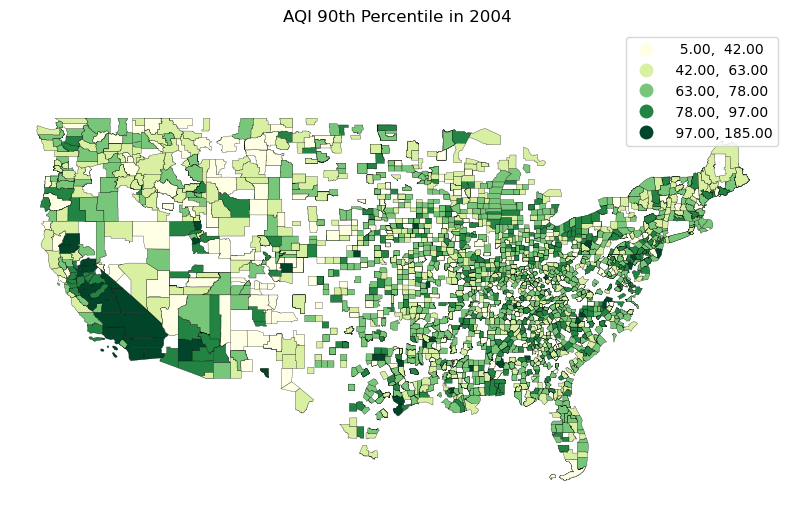

In [66]:
fig, ax = plt.subplots(figsize=(10,8))

county_2004.plot(ax=ax, column='90th Percentile AQI',
                cmap='YlGn', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("AQI 90th Percentile in 2004");

plt.savefig('90th_2004.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

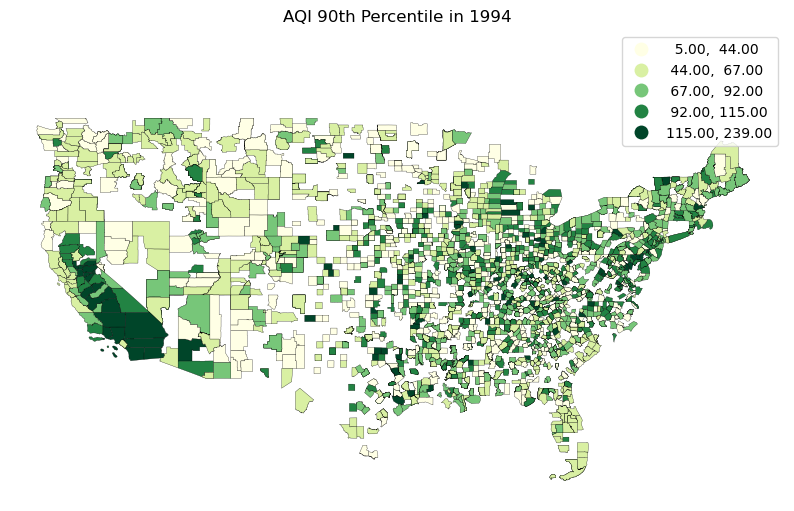

In [67]:
fig, ax = plt.subplots(figsize=(10,8))

county_1994.plot(ax=ax, column='90th Percentile AQI',
                cmap='YlGn', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("AQI 90th Percentile in 1994");

plt.savefig('90th_1994.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

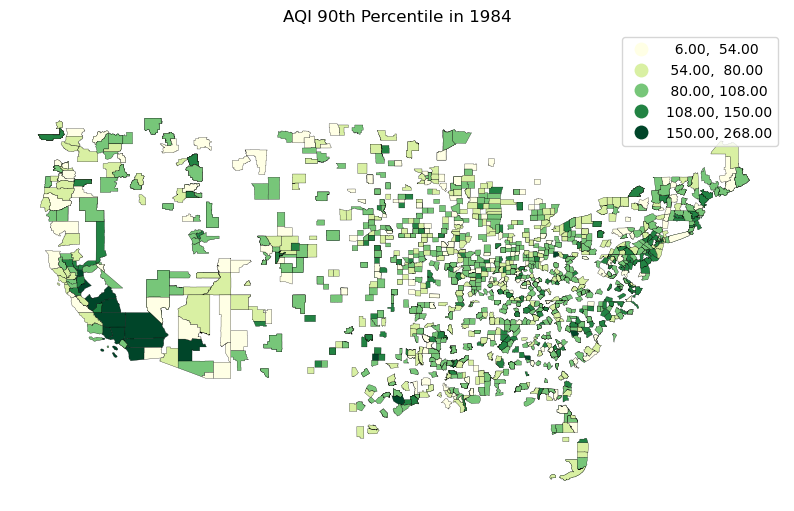

In [68]:
fig, ax = plt.subplots(figsize=(10,8))

county_1984.plot(ax=ax, column='90th Percentile AQI',
                cmap='YlGn', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("AQI 90th Percentile in 1984");

plt.savefig('90th_1984.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

More counties had increased values for their 90th percentiles.

## Pollutants

### PM2.5

I wanted to compare PM2.5 values across years due to it being a large pollutant present in wildfire smoke.

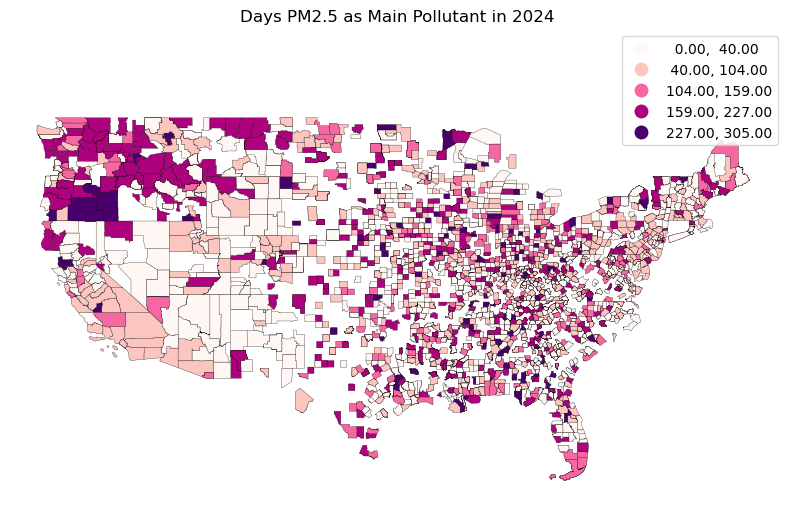

In [39]:
fig, ax = plt.subplots(figsize=(10,8))

# generating a choropleth map with quantiles based on the "Days PM2.5" column
# used a different color map to differentiate with other maps
county_2024.plot(ax=ax, column='Days PM2.5',
                cmap='RdPu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days PM2.5 as Main Pollutant in 2024");

plt.savefig('pm2.5_2024.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

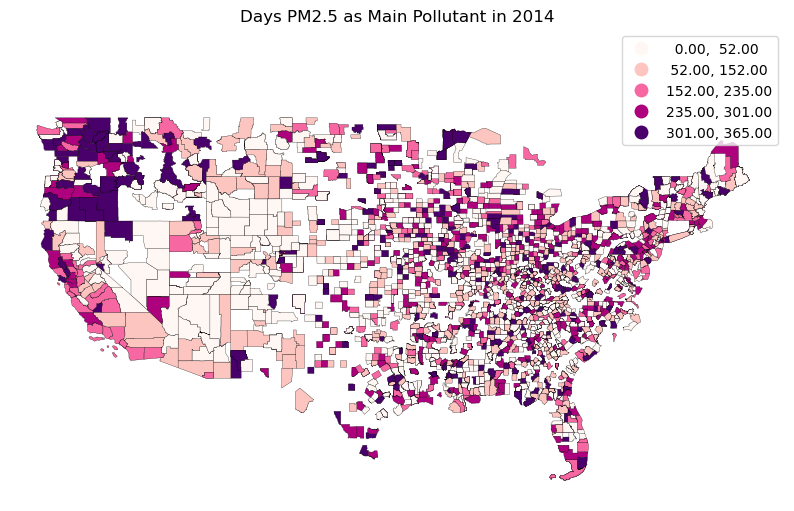

In [40]:
fig, ax = plt.subplots(figsize=(10,8))

county_2014.plot(ax=ax, column='Days PM2.5',
                cmap='RdPu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days PM2.5 as Main Pollutant in 2014");

plt.savefig('pm2.5_2014.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

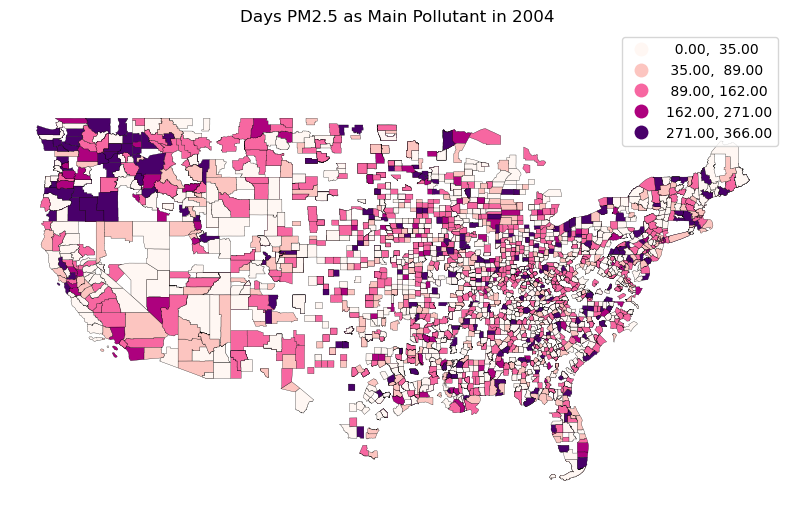

In [41]:
fig, ax = plt.subplots(figsize=(10,8))

county_2004.plot(ax=ax, column='Days PM2.5',
                cmap='RdPu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days PM2.5 as Main Pollutant in 2004");

plt.savefig('pm2.5_2004.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

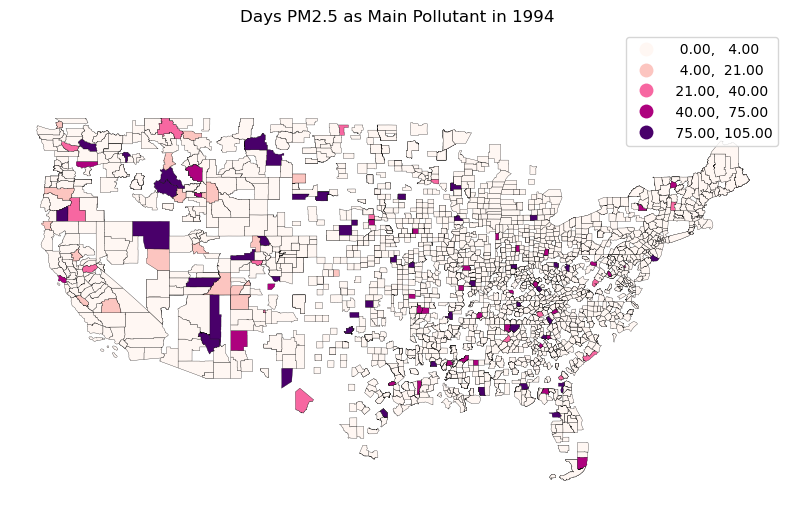

In [42]:
fig, ax = plt.subplots(figsize=(10,8))

county_1994.plot(ax=ax, column='Days PM2.5',
                cmap='RdPu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days PM2.5 as Main Pollutant in 1994");

plt.savefig('pm2.5_1994.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [36]:
county_1984.head()

STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ       NAME   
0      31      109  00835876  31109  0500000US31109  Lancaster  \
1      31      109  00835876  31109  0500000US31109  Lancaster   
2      45      057  01248008  45057  0500000US45057  Lancaster   
3      45      057  01248008  45057  0500000US45057  Lancaster   
4      42      071  01209181  42071  0500000US42071  Lancaster   

           NAMELSAD LSAD CLASSFP  MTFCC  ... Very Unhealthy Days   
0  Lancaster County   06      H1  G4020  ...                   0  \
1  Lancaster County   06      H1  G4020  ...                   0   
2  Lancaster County   06      H1  G4020  ...                   0   
3  Lancaster County   06      H1  G4020  ...                   0   
4  Lancaster County   06      H1  G4020  ...                   0   

  Hazardous Days Max AQI 90th Percentile AQI  Median AQI  Days CO Days NO2   
0              0      84                  42          24      189        0  \
1              0     195                  78          40       13      218   
2              0      84                  42          24      189        0   
3              0     195                  78          40       13      218   
4              0      84                  42          24      189        0   

  Days Ozone Days PM2.5 Days PM10  
0        177          0         0  
1        133          0         0  
2        177          0         0  
3        133          0         0  
4        177          0         0  

[5 rows x 36 columns]

All values in the 'Days PM2.5' column for 1984=0.

In [43]:
county_1984['Days PM2.5']

0       0
1       0
2       0
3       0
4       0
       ..
2080    0
2081    0
2082    0
2083    0
2084    0
Name: Days PM2.5, Length: 2085, dtype: int64

ValueError: Fewer unique values (1) than specified classes (5).

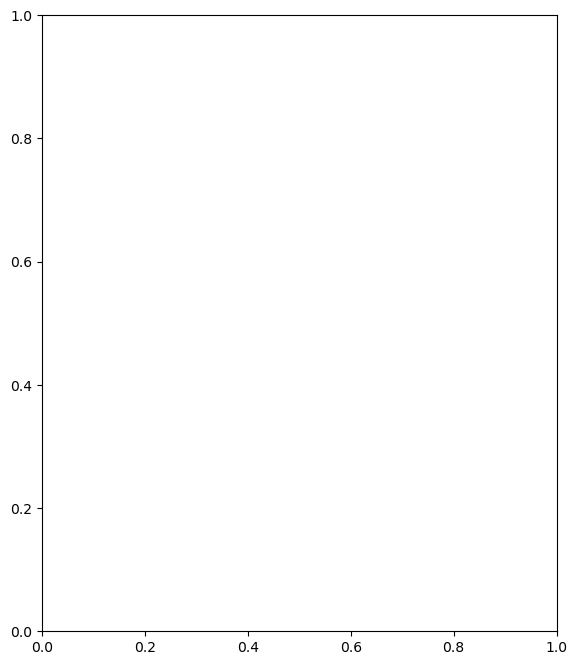

In [50]:
# will fail due to there not being enough different values in the Days PM2.5 column for the numbers of quantiles
# there are only zeroes in the column
fig, ax = plt.subplots(figsize=(10,8))
county_1984.plot(ax=ax, column='Days PM2.5',
                cmap='OrRd', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days PM2.5 as Main Pollutant in 1984");
plt.savefig('pm2.5_1984.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Here I have the maps comaring 2024 to 1994, instead of 1984. Overall, there were more days with PM2.5 as the main pollutant.

### Ozone

Comparing ozone due to it being a concern with rising temperatures.

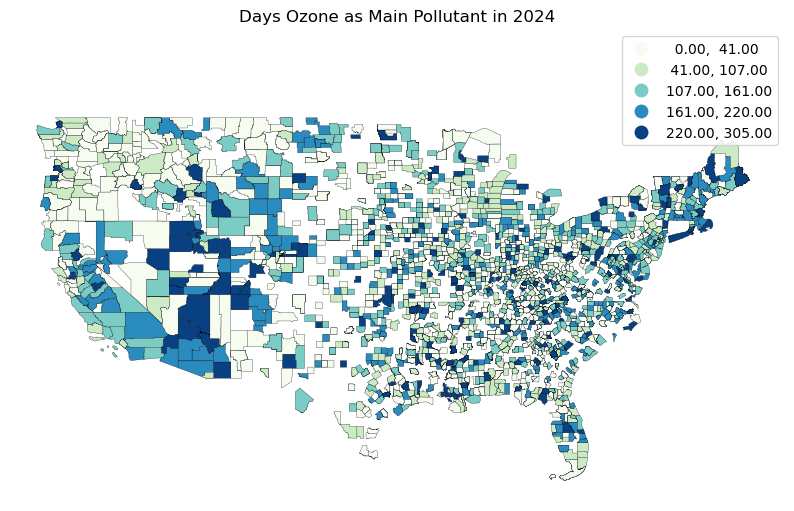

In [45]:
fig, ax = plt.subplots(figsize=(10,8))

# generating a choropleth map with quantiles based on the "Days Ozone" column
# used a different color map to differentiate with other maps
county_2024.plot(ax=ax, column='Days Ozone',
                cmap='GnBu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days Ozone as Main Pollutant in 2024");

plt.savefig('ozone_2024.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

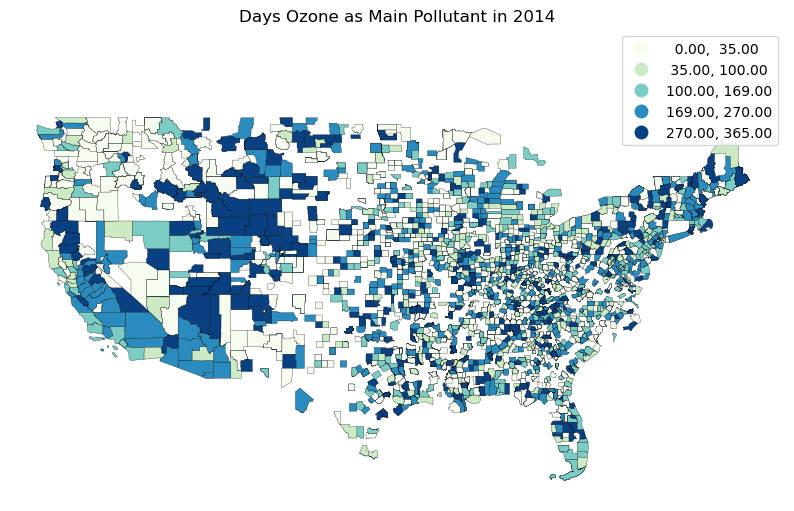

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

county_2014.plot(ax=ax, column='Days Ozone',
                cmap='GnBu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days Ozone as Main Pollutant in 2014");

plt.savefig('ozone_2014.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

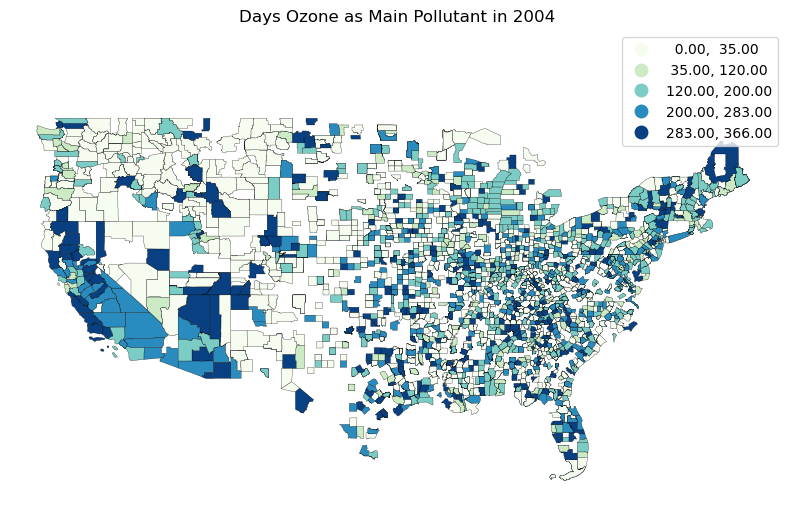

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

county_2004.plot(ax=ax, column='Days Ozone',
                cmap='GnBu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days Ozone as Main Pollutant in 2004");

plt.savefig('ozone_2004.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

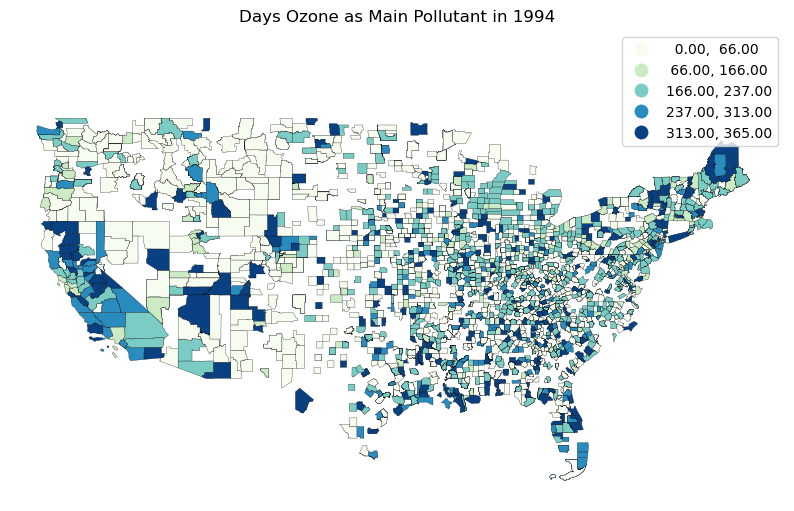

In [48]:
fig, ax = plt.subplots(figsize=(10,8))

county_1994.plot(ax=ax, column='Days Ozone',
                cmap='GnBu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days Ozone as Main Pollutant in 1994");

plt.savefig('ozone_1994.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

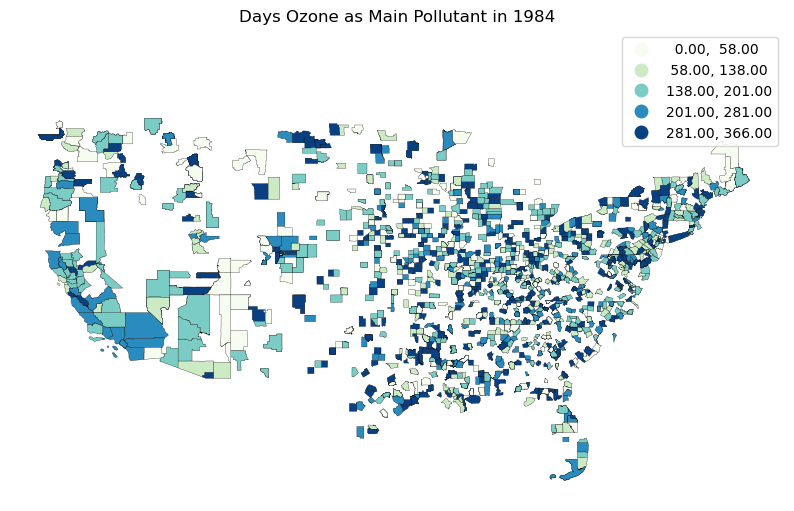

In [49]:
fig, ax = plt.subplots(figsize=(10,8))

county_1984.plot(ax=ax, column='Days Ozone',
                cmap='GnBu', edgecolor="black", linewidth=0.2,
                legend='true', scheme='fisher_jenks');
ax.set_xlim(-127, -64)
ax.set_ylim(23, 55)
ax.set_axis_off()
ax.set_title("Days Ozone as Main Pollutant in 1984");

plt.savefig('ozone_1984.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

Days with ozone as the main pollutant appear to be increasing until 2024, where there was a slight drop.

## Conclusion

The main takeaways from my findings were that there was more data from more counties over time. I hadn't anticipated that, but it was very interesting seeing more counties being added as the years progressed. Most of the variables I looked at increased over 40 years, PM2.5 being the most apparent. 